<a href="https://colab.research.google.com/github/aleGuerriero/fBots/blob/main/AIF_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokémon VGC AI Competition

## Course  
- **Artificial Intelligence Fundamentals** (University of Pisa)

## Year  
- **2024/2025**  

## Authors  
- **Alessandro Guerriero**  
- **Riccardo Berni**  
- **Elia Boccini**  


---
## Introduction  
In this notebook, we will examine our project related to the **Pokémon VGC AI competition** [1], an event that explores the intersection of artificial intelligence and competitive Pokémon battles.

The goal of our work is to develop an AI system capable of tackling challenges in the Pokémon VGC (Video Game Championships) competition, using algorithms and techniques learned during the course of *Artificial Intelligence Fundamentals*.  

Following a brief introduction to the implementation environment, this report outlines the methodologies, results, and key insights of our project, with a focus on both the development process and performance evaluation.

### Pokémon VGC Engine
The pokémon VGC Engine is a new model of Meta-Game Balance AI Competition. It is composed of two main tracks:
-  Battle Track
  - Simulates turn-based battles following VGC rules
  - The player agent competes against opponents
  - Three matches for round

- VGC Track
  - Player agents compete in a full VGC
  - It includes team bulding and Meta-Game analysis

The repository of the VGC AI Framework can be found [here](https://gitlab.com/DracoStriker/pokemon-vgc-engine).










In [ ]:
%%capture cell
!git clone https://gitlab.com/DracoStriker/pokemon-vgc-engine.git
!pip install ./pokemon-vgc-engine

In [ ]:
# Importing useful libraries
from typing import Any, List, Union
from copy import deepcopy

import math
import numpy as np
import random

In [ ]:
# Importing from pokemon VGC environment

from vgc.behaviour import BattlePolicy
from vgc.datatypes.Types import PkmStatus
from vgc.datatypes.Objects import GameState, PkmTeam, PkmType, Pkm
from vgc.datatypes.Constants import DEFAULT_N_ACTIONS, TYPE_CHART_MULTIPLIER
from vgc.competition.StandardPkmMoves import STANDARD_MOVE_ROSTER

### Enviroment
For our project we focuse on the Battle track.

The following image and explanation illustrate the **Battle Phase Framework**, as described in the original paper of the VGC AI Competition [1].



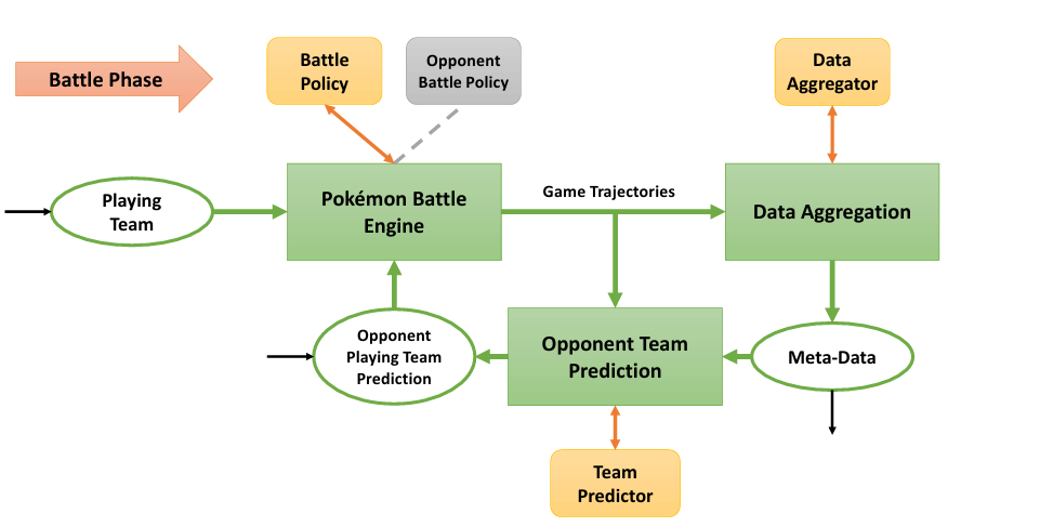

In [3]:
from IPython.display import Image, display
display(Image(filename="/enviroment.png",width=450, height=230))


*\"A Battle Phase is composed of three processes, the PBE which
interacts with a pair of battle policies, a data aggregation process and team predictor. Game states and joint actions are propagated in trajectories and delivered to Team Predictors to update their opponents team prediction. (...) There is a loop in the information flow, the PBE runs until the game reaches a terminal condition."* [1]

The Team Selector used in our test environment is a Random Selector. A Battle Competition consists of ten matches. The first five matches are played with the randomly selected teams, while in the last five matches, the teams are switched between the two competitors. A match is won by the first competitor to achieve two victories in battles.

In our work, we developed various Battle Policies for our agent and evaluated their performance by testing them against different Opponent Battle Policies.

### Objectives  
- Create an AI system capable of simulating and competing in Pokémon VGC battles.  
- Apply AI algorithms and strategic research to improve the system's performance.  
- Analyze the results and compare them with previous approaches.

---
## Related  Works

The development of AI systems for Pokémon VGC has been a topic of significant interest in recent years. Numerous research efforts and projects have been dedicated to creating strategies that enable AI to effectively compete in Pokémon battles. These works primarily focus on simulating game mechanics, optimizing battle strategies, and enhancing the decision-making process through machine learning and deep reinforcement learning.

Previous studies have explored a variety of approaches, including rule-based systems, evolutionary algorithms, and neural networks. Here, we discuss notable contributions to this field that have informed the design and implementation of AI systems for Pokémon VGC.
**Mnih et al. (2015)** introduced a groundbreaking approach to reinforcement learning through the development of Deep Q-Networks (DQNs), achieving human-level performance in a variety of video games. Although not specifically designed for Pokémon, their work [2] laid the foundation for the use of deep reinforcement learning in strategic and complex decision-making tasks, which are essential for Pokémon battles. **Rodriguez, Villanueva, and Baldeón (2024)** applied deep reinforcement learning and neuroevolution techniques to enhance the performance of AI agents in Pokémon VGC competitions [3]. Their study highlights the effectiveness of combining neuroevolutionary strategies with reinforcement learning to optimize team composition and battle tactics, demonstrating improvements in both adaptability and competitive success.
**Reis et al. (2024)** proposed an adversarial approach for automated Pokémon team building and metagame balance [4]. This work focuses on leveraging adversarial strategies to improve AI-driven team construction, addressing the dynamic nature of the competitive Pokémon metagame. Their contributions are particularly valuable for understanding the role of team synergy and counterplay in achieving competitive balance.
**Saffidine, Finnsson, and Buro (2021)** investigated the application of alpha-beta pruning algorithms for games with simultaneous moves, such as Pokémon battles [5]. By optimizing decision trees in real-time, their work provides insights into improving computational efficiency in AI decision-making processes, which is critical for the high-paced nature of competitive Pokémon gameplay.

In summary, these studies collectively highlight the diversity of approaches and methodologies employed in developing AI systems for Pokémon VGC. From foundational reinforcement learning frameworks to domain-specific adaptations, these works form the basis for advancing AI-driven strategies in competitive Pokémon battles.



---
## Methodologies  
The main methodologies used in our project include:  
- **Greedy Approaches**: focusing on choosing the best immediate action, ignoring the opponent.
- **MiniMax algorithm**: exploring the game tree supposing that the opponent will play his best move.
- **AlphaBeta Pruning**: pruning the game tree avoiding to explore useless branches.




### Policies

The core of each policy is defined in the {get_step()} method of the {Policy} superclass. For each kind of policy the main steps to choose an action are:  
  1. Evaluate the current state
  2. Evaluate possible future state
  3. Pick the best move

#### AlphaBeta Policy
AlphaBeta Policy implements a minimax algorithm with alpha-beta pruning in the context of the pokemon VGC environment.  
Due to the simultaneous nature of pokemon battles, the tree search for the minimax algorithm is performed on couples of action (one for each player). Enumerating all the possible couples the agent evaluates the best game-state from both perspective choosing to expand nodes and simulate a new step only on nodes that lead to better game-state for either player.

In [ ]:
class Node():

  def __init__(self):
    self.action: int = None
    self.gameState: GameState = None
    self.parent: Node = None
    self.depth: int = 0
    self.value: float = 0.

  def __str__(self):
    return f'Node(action: {self.action}, depth: {self.depth}, value: {self.value}, parent: {str(self.parent)})'

##### Evaluation Function
The evaluation function takes into account different features which can determine the results of a pokemon battle. It tries to approximate many factors like an estimate of the quality of the current match-up focusing on the typing of the available moves of both pokemon.

In [ ]:
def match_up_eval(my_pkm_type: PkmType,
      opp_pkm_type: PkmType,
      my_moves_type: List[PkmType],
      opp_moves_type: List[PkmType]
  ) -> float:
  # Determine defensive matchup
  defensive_match_up = 0.
  for mtype in opp_moves_type:
    if mtype == opp_pkm_type:
      defensive_match_up = max(TYPE_CHART_MULTIPLIER[mtype][my_pkm_type]*1.5, defensive_match_up)
    else:
      defensive_match_up = max(TYPE_CHART_MULTIPLIER[mtype][my_pkm_type], defensive_match_up)
  # Determine offensive matchup
  offensive_match_up = 0.
  for mtype in my_moves_type:
    if mtype == opp_pkm_type:
      offensive_match_up = max(TYPE_CHART_MULTIPLIER[mtype][opp_pkm_type]*1.5, offensive_match_up)
    else:
      offensive_match_up = max(TYPE_CHART_MULTIPLIER[mtype][my_pkm_type], offensive_match_up)

  return offensive_match_up - defensive_match_up

It also gives an evalution of statuses and stages of both active pokemons.

In [ ]:
def status_eval(pkm: Pkm) -> float:
  if pkm.status == (PkmStatus.CONFUSED or PkmStatus.PARALYZED or PkmStatus.SLEEP or PkmStatus.FROZEN):
    return -1
  elif pkm.status == (PkmStatus.BURNED or PkmStatus.POISONED):
    return -0.5
  else:
    return 0

def stage_eval(team: PkmTeam) -> int:
  stage: int = 0
  for s in team.stage:
    stage += s
  return stage

Mixing all togheter with other useful metrics to evaluate the current state.

In [ ]:
def game_state_eval(g: GameState, depth: int):
  my_team = g.teams[0]
  opp_team  = g.teams[1]
  my_active: Pkm = my_team.active
  opp_active: Pkm = opp_team.active
  match_up: float = match_up_eval(my_active.type, opp_active.type,
      list(map(lambda m: m.type, my_active.moves)),
      list(map(lambda m: m.type, [move for move in opp_active.moves if move.name != None])))

  my_stage = stage_eval(my_team)
  opp_stage = stage_eval(opp_team)
  my_status = status_eval(my_active)
  opp_status = status_eval(opp_active)
  return (match_up
          + my_active.hp/my_active.max_hp*3
          - opp_active.hp/opp_active.max_hp*3
          + 0.2*my_stage
          - 0.2*opp_stage
          + my_status
          - opp_status
          - 0.3*math.ceil(depth/2)
          + (my_team.party[0].hp/my_team.party[0].max_hp+my_team.party[1].hp/my_team.party[1].max_hp)*2)

##### Policy

The policy is implemented extending the BattlePolicy superclass. It explores the game-states tree using a minimax algorithm with alpha-beta pruning and early stopping at a given depth.  
In the early turns of a battle most of the opponent moves are unknown, thus a function that chooses random moves from the pokemon moves pool is used to estimate a sligthly morre acurate turn. As the match continue, new moves are discovered and the random ones replaced.

In [ ]:
def estimate_move(pkm: Pkm) -> None:
  # Check if a STAB move is in the pokemon moves
  type_m = sum([move.type==pkm.type for move in pkm.moves if move.name is not None])
  for move_i in range(DEFAULT_N_ACTIONS-2):
    if pkm.moves[move_i].name is None:
      # If not STAB move add a random one, chose only between damage moves (the most dangerous)
      if type_m==0:
        type_moves = [move for move in STANDARD_MOVE_ROSTER if move.type==pkm.type and move.power>0.0]
        pkm.moves[move_i] = random.choice(type_moves)
        type_m = 1
      else:
        # No repeating moves
        move = random.choice(STANDARD_MOVE_ROSTER)
        while(move in pkm.moves):
          move = random.choice(STANDARD_MOVE_ROSTER)
        pkm.moves[move_i] = move

Other utility functions used in the minimax loop to determine if a state is final.

In [ ]:
def n_fainted(team: PkmTeam) -> int:
  fainted = 0
  fainted += team.active.hp == 0
  if len(team.party) > 0:
    fainted += team.party[0].hp == 0
  if len(team.party) > 1:
    fainted += team.party[1].hp == 0
  return fainted

The AlphaBeta policy is so defined.

In [ ]:
class AlphaBetaPolicy(BattlePolicy):

  def __init__(self, max_depth: int = 6, seed: int = 69):
    self.max_depth = max_depth
    random.seed(seed)

  def get_action(self, g: GameState) -> int:
    root: Node = Node()
    root.gameState = g
    estimate_move(root.gameState.teams[1].active)
    action = self._alphaBeta_search(root)
    return action

  def _alphaBeta_search(
      self,
      root: Node,
      alpha: float = -np.inf,
      beta: float = np.inf
  ) -> int:

    value, move = self._max_value(root, alpha, beta)

    return move

  def _max_value(
      self,
      node: Node,
      alpha: float,
      beta: float
  ) -> tuple[float, Union[int, None]]:
    state: GameState = deepcopy(node.gameState)

    if state.teams[1].active.hp == 0 or state.teams[0].active.hp == 0 or node.depth >= self.max_depth:
      return game_state_eval(state, node.depth), None
    value = -np.inf
    for i in range(DEFAULT_N_ACTIONS):
      next_node: Node = Node()
      next_node.parent = node
      next_node.depth = node.depth + 1
      next_node.action = i
      next_node.gameState = state
      next_node.value, _ = self._min_value(next_node, alpha, beta)

      if next_node.value > value:
        value, move = next_node.value, next_node.action
        alpha = max(value, alpha)
      if value >= beta:
        return value, move
    return value, move

  def _min_value(
      self,
      node: Node,
      alpha: float,
      beta: float
  ) -> tuple[float, Union[int, None]]:
    state: GameState = deepcopy(node.gameState)
    value = np.inf
    for i in range(DEFAULT_N_ACTIONS):
      next_state, _, _, _, _ = state.step([node.action, i])
      next_node: Node = Node()
      next_node.parent = node
      next_node.depth = node.depth + 1
      next_node.action = i
      next_node.gameState = next_state[0]
      next_node.value, _ = self._max_value(next_node, alpha, beta)
      if next_node.value < value:
        value, move = next_node.value, next_node.action
        beta = min(value, beta)
      if value <= alpha:
        return value, move
    return value, move

#### Hybrid Policy
The MiniMax algorithm struggles in the early rounds, when the opponent's moves are unknown. On the other hand, a greedy approach is able to approximate a good move effectively when the opponent's moves are not considered.

For this reason we implemented an **hybrid policy** that combines the best features of these techniques. It is realized as follows:
  - **AlphaBeta Policy** is used (as descripted earlier) when at least 2 of the opponent's moves are known.
  - **Greedy Policy** is used when zero or only one move is known.

Below is a description of the Greedy Policy, with a focus on its most relevant aspects.

##### Greedy Policy
This approach tries to find the best move in terms of damage and chance of defeating the opponents, analyzing the stats and type advantage.

The first step is to check if there is a move that can defeat the opposing Pokémon in one turn, considering the attack order. Obviously, if such a move exists and our Pokémon attacks first, it is chosen.

Further details are provided in the code comments.

In [ ]:
# check who attacks first
attack_order = canAttackFirst(team0, team1, team1.active)

# check if I can defeat the opponent with a move
moves = canDefeat(team0.stage[PkmStat.ATTACK], team1.stage[PkmStat.DEFENSE], team0.active, team1.active, weather)
# if I can defeat them
if len(moves) > 0:

  # if I surely attack first, choose the most accurate move with the highest PP that defeats them
  if attack_order == 1:
    return moves[0][0]

  # if the opponent has a priority move, check if it cannot defeat me
  elif attack_order == 0.5:
    if calculate_damage([m for m in opp_active.moves if m.priority == True][0], opp_active.type, my_active.type, team1.stage[PkmStat.ATTACK], team0.stage[PkmStat.DEFENSE], weather) < my_active.hp:
      return moves[0][0]

  # if the opponent is faster
  if attack_order <= 0:
    # if I have a priority move that defeats them, choose it
    if sum([m[4] for m in moves]) >= 1:
      return [m[0] for m in moves if m[4] == True][0]
    # if the opponent still cannot defeat me with a move, choose my move that defeats them
    if len(canDefeat(team1.stage[PkmStat.ATTACK], team0.stage[PkmStat.DEFENSE], team1.active, team0.active, weather)) == 0:
      return moves[0][0]


Next, it checks whether our Pokémon is at risk of being defeated in a single turn. If so, the agent attempts to inflict a status effect (such as CONFUSED, PARALYZED, SLEEP or FROZEN) on the opposing Pokémon, aiming to attack first.

In [ ]:
# if the opponent can defeat me with a move, try to inflict a status condition if possible
if len(canDefeat(team1.stage[PkmStat.ATTACK], team0.stage[PkmStat.DEFENSE], team1.active, team0.active, weather)) > 0:
  stateMoves = [m for m in my_active.moves if m.target == 1 and (m.status == PkmStatus.CONFUSED or m.status == PkmStatus.PARALYZED or m.status == PkmStatus.SLEEP or m.status == PkmStatus.FROZEN)]

  # if I have any status moves
  if len(stateMoves) > 0:
    # check if there's one that inflicts sleep or freeze, if so choose it; otherwise, pick any
    sleep = [my_active.moves.index(m) for m in stateMoves if m.status == PkmStatus.SLEEP]
    ice = [my_active.moves.index(m) for m in stateMoves if m.status == PkmStatus.FROZEN]
    if len(sleep) > 0:
      return sleep[0]
    elif len(ice) > 0 and opp_active.type != PkmType.ICE:
      return ice[0]
    else:
      return my_active.moves.index(stateMoves[0])

If defeating the opposing Pokémon requires multiple turns, it analyzes the situation and the type advantage, taking into account the other Pokémon in the party as well.

If our Pokémon doesn't have a significant disadvantage, the opponents are fainted, or no other Pokémon has a better matchup, the active Pokémon remains in play, and the algorithm proceeds as follows:

  - It calculates moves that can defeat the opposing Pokémon within a maximum of 3 turns. If at least one such move exists, the strongest one is chosen.
  - If no such moves are available, it checks for status moves. If any are found, the most important one is selected.
  - If neither offensive nor status moves are available, the most powerful move is chosen, taking accuracy into account.



In [ ]:
# if I cannot defeat the opponent with one move, check:
# if I'm in an acceptable situation, or my team is exhausted, or I'm at a disadvantage but have no better switches, keep the Pokémon in the field
if match_up >= 0.5 or n_fainted(team0) == 2 or (match_up < 0.5 and not (pkm1_match_up > match_up or pkm2_match_up > match_up)):
  # calculate the damage of my moves
  damages = calculateDamages(team0.stage[PkmStat.ATTACK], team1.stage[PkmStat.DEFENSE], team0.active, team1.active, weather)

  # check if I can defeat the opponent within 3 turns
  beatMoves = []
  for move in damages:
    if move[1] * math.floor(3 * move[3]) > opp_active.hp:
      beatMoves.append(move)

  # if I don't have moves that could defeat the opponent in 3 turns, check if I have status moves
  if len(beatMoves) == 0:
    stateMoves = [m for m in damages if m[6] == 1 and (m[5] == PkmStatus.CONFUSED or m[5] == PkmStatus.PARALYZED or m[5] == PkmStatus.SLEEP or m[5] == PkmStatus.FROZEN)]
    # if I have any status moves
    if len(stateMoves) > 0:
      # check if there's one that inflicts sleep or freeze, if so choose it; otherwise, pick any
      sleep = [m[0] for m in stateMoves if m[5] == PkmStatus.SLEEP]
      ice = [m[0] for m in stateMoves if m[5] == PkmStatus.FROZEN]
      if len(sleep) > 0:
        return sleep[0]
      elif len(ice) > 0 and opp_active.type != PkmType.ICE:
        return ice[0]
      else:
        return stateMoves[0][0]
    # if I don't even have status moves, pick the most powerful move I have based on power and accuracy
    else:
      damages.sort(reverse=True, key=lambda x: (x[1] * x[3]))
      return damages[0][0]

  # if I have at least one move that defeats the opponent in 3 turns, choose:
  else:
    # sort beatMoves to select the one that deals the most damage
    # (even though the most powerful moves might be less accurate, it's acceptable as accuracy has already been considered)
    beatMoves.sort(reverse=True, key=lambda x: (x[1]))
    return beatMoves[0][0]


If none of the previous conditions are met, the algorithm then considers switching to a Pokémon that has the best matchup.

In [ ]:
else:
  if pkm1_match_up >= pkm2_match_up:
    if not team0.party[0].fainted():
      return 4
    else:
      return 5
  else:
    if not team0.party[1].fainted():
      return 5
    else:
      return 4

---
## Evaluation

To evaluate our policies, we employed a multi-step approach:

1. Battles against fixed policies: we tested our policies against a predefined set of policies provided by the competition.
2. Comparison with previous competition agents: our policies were evaluated against policies from last year's competition agents.
3. Tournament: finally, we organized a tournament involving all the different policies to comprehensively assess their performance.


The table below presents the results of *Tests 1 and 2*, conducted against various opponents. For each opponent, we ran a series of tests comparing the performance of our policies. The policies from previous years are marked with "*".


| Our Policy   | Max Depth | Opponent Policy | Mean % Matches Wins | Number of Tests |
|--------------|-----------|------------------|---------------------|-----------------|
| AlphaBeta    | 2.0       | Hayo5*           | 32.320             | 25              |
| AlphaBeta    | 4.0       | Hayo5*           | 36.533             | 15              |
| Greedy       | -       | Hayo5*           | 38.880             | 25              |
| Mixed        | 2.0       | Hayo5*           | 39.040             | 25              |
| Mixed        | 4.0       | Hayo5*           | 41.733             | 15              |
| Mixed        | 6.0       | Hayo5*           | 45.500             | 12              |
|----------------|-----------------|--------------------------|------------------------------------|---------------------------|
| AlphaBeta    | 2.0       | MiniMax         | 36.000             | 2               |
| AlphaBeta    | 4.0       | MiniMax         | 54.000             | 2               |
| Greedy       | -       | MiniMax         | 55.385             | 13              |
| Mixed        | 2.0       | MiniMax         | 58.000             | 3               |
|----------------|-----------------|--------------------------|------------------------------------|---------------------------|
| AlphaBeta    | 2.0       | PrunedBFS       | 51.040             | 25              |
| Greedy       | -       | PrunedBFS       | 49.440             | 25              |
| Mixed        | 2.0       | PrunedBFS       | 52.240             | 25              |
| Mixed        | 4.0       | PrunedBFS       | 55.733             | 30              |
| Mixed        | 6.0       | PrunedBFS       | 55.143             | 7               |
|----------------|-----------------|--------------------------|------------------------------------|---------------------------|
| AlphaBeta    | 2.0       | Thunder*         | 31.320             | 50              |
| AlphaBeta    | 4.0       | Thunder*         | 37.120             | 50              |
| AlphaBeta    | 6.0       | Thunder*         | 40.000             | 13              |
| Greedy       | -       | Thunder*         | 34.560             | 25              |
| Mixed        | 2.0       | Thunder*         | 40.720             | 50              |
| Mixed        | 4.0       | Thunder*         | 43.160             | 50              |
| Mixed        | 6.0       | Thunder*         | 42.364             | 44              |






The results clearly demonstrate the superior performance of the hybrid policy compared to the other approaches in battles against each opponent.

Below are the standings from some tournaments conducted as part of *Test 3*. Each policy represents a specific agent strategy, and Pokémon teams were chosen randomly. Every agent participated in a series of ten matches against each other, with teams switching at the halfway point. The score indicates the number of matches won by each agent's policy.

| Rank | Policy       | Score | --- | Rank | Policy       | Score | --- | Rank | Policy       | Score |
|------|--------------|-------|----|------|--------------|-------|----|------|--------------|-------|
| 1    | Hayo5*       | 40    |  --- | 1    | Mixed2       | 39    |  --- | 1    | Hayo5*       | 42    |
| 2    | Thunder*      | 39    |  --- | 2    | Thunder*      | 37    |  --- | 2    | Mixed4       | 41    |
| 3    | Mixed2       | 38    |  --- | 3    | Hayo5*       | 37    |  --- | 3    | Mixed2       | 37    |
| 4    | AlphaBeta4   | 37    |  --- | 4    | Mixed4       | 36    |  --- | 4    | Thunder*      | 35    |
| 5    | Mixed4       | 37    |  --- | 5    | Greedy       | 35    |  --- | 5    | AlphaBeta4   | 33    |
| 6    | Greedy       | 34    |  --- | 6    | AlphaBeta4   | 34    |  --- | 6    | PrunedBFS    | 33    |
| 7    | PrunedBFS    | 29    |  --- | 7    | PrunedBFS    | 32    |  --- | 7    | Greedy       | 32    |
| 8    | MiniMax      | 26    |  --- | 8    | MiniMax      | 30    |  --- | 8    | MiniMax      | 27    |


| Rank | Policy       | Score | --- | Rank | Policy       | Score | --- | Rank | Policy       | Score |
|------|--------------|-------|----|------|--------------|-------|----|------|--------------|-------|
| 1    | Hayo5*       | 30    |  --- | 1    | Mixed6       | 28    |  --- | 1    | Hayo5*       | 29    |
| 2    | AlphaBeta4   | 28    |  --- | 2    | Thunder*      | 27    |  --- | 2    | AlphaBeta4   | 26    |
| 3    | Mixed6      | 25    |  --- | 3    | Hayo5*       | 27    |  --- | 3    | Thunder*      | 26    |
| 4    | Thunder*       | 25    |  --- | 4    | AlphaBeta4   | 26    |  --- | 4    | Mixed6       | 25    |
| 5    | Greedy       | 21    |  --- | 5    | Greedy       | 21    |  --- | 5    | Greedy       | 22    |
| 6    | PrunedBFS    | 21    |  --- | 6    | PrunedBFS    | 21    |  --- | 6    | PrunedBFS    | 22    |


These standings highlight how the Mixed policy consistently outperforms both Minimax and PrunedBFS, demonstrating its superior effectiveness. Additionally, the results show that Mixed (Hybrid) policy can perform at a level comparable to, or even surpass, last year's top-performing agents.

---
## Further Development: SMAB

The tests yielded satisfactory results in terms of winning percentage. However, we are confident that these results can be further improved through additional developments.

We are exploring new techniques to apply to our task. In the following section, we will briefly introduce SMAB [5], a new method we are considering for implementation.

## Alpha-Beta Pruning for Games with Simultaneous Moves
This method introduces an innovative approach for games with **simultaneous moves**, like multi-agent systems or strategic board games, where traditional alpha-beta pruning faces challenges due to the complex nature of decision-making.

Unlike sequential games, where actions are taken one after the other, each player chooses their actions independently. The state space grows exponentially as players' decisions interact. This leads to a large number of possible action combinations.

The game can be represented as a **utility matrix**, where each element $𝑈[𝑖][𝑗]$ corresponds to the outcome (utility) for a specific combination of actions taken by all players. For example, in a two-player game:
$$
\text{Utility Matrix} =
\begin{bmatrix}
U(1, 1) & U(1, 2) & U(1, 3) \\
U(2, 1) & U(2, 2) & U(2, 3)
\end{bmatrix}
$$

Each row and column represent the actions of *Player 1* and *Player 2*, respectively, and the values represent the outcome of these action combinations.

Similar to traditional **alpha-beta pruning**, the method involves maintaining upper and lower bounds (alpha and beta) for the possible outcomes.
By applying alpha-beta pruning in the context of a utility matrix, we can efficiently navigate the large combinatorial space of simultaneous move games, reducing unnecessary computations and focusing on the most promising branches.

This approach is particularly useful in games like two-player board games (e.g., chess, Go) or multi-agent systems, where the decision-making process is inherently simultaneous. For these reasons, we are confident that a SMAB-based policy will significantly enhance the project's performance.

---
## Conclusion
In summary, we began with the implementation of the AlphaBeta algorithm, adapted to our specific task, which performed quite well.
Next, we combined the AlphaBeta policy with a greedy approach, resulting in notable improvements.

Overall, the tests produced satisfactory results, even when compared against agents from previous years. However, we observed high variance in the results, likely due to random team selection.

This work is still ongoing, and we plan to explore additional approaches, such as the SMAB method, to further enhance outcomes.

The GitHub repository for the project is available [here](https://github.com/aleGuerriero/fBots).

---
## Appendix

### 1. Team Contributions  
- **Alessandro Guerriero**: Developed the AlphaBeta policy and the BattleTester tool.  
- **Riccardo Berni**: Focused on testing, evaluation, and reporting the results of the models.  
- **Elia Boccini**: Integrated the AlphaBeta policy with the Greedy approach (hybrid strategy) and improved the evaluation function.  

While these roles highlight key areas of contribution, the work was highly collaborative. Regular discussions and joint efforts ensured shared responsibility for key updates and implementations through iterative development.

### 2. GitHub Metrics  
- **Contributors**: 3 contributors (Alessandro, Riccardo and Elia) actively contributed to the repository.  
  - `riccardoberni` with 26 commits and 1,537 additions.
  -`aleGuerriero` with 11 commits and 11,521 additions.
  -`Elia-bocc` with 11 commits and 566 additions.

### 3. Relationship with the Course  
- **Course Objectives**:  Our project aligns with the course's focus on Adversarial Learning, Minimax algorithm, and Alpha-Beta Pruning techniques.
- **Knowledge Application**: We applied adversarial learning models to our tasks and implemented these strategies using GitHub for version control, ensuring collaboration and tracking of progress throughout the project.
- **Course Resources**: Course lectures, slides, and the *AIMA* ("*Artificial Intelligence: A Modern Approach*") reference book provided foundational insights into AI models and strategies for adversarial learning, which we directly applied to our project.


---
## References

[1] [S. Reis, L. P. Reis and N. Lau](https://gitlab.com/DracoStriker/pokemon-vgc-engine/-/wikis/home) (2021) "*VGC AI Competition - A New Model of Meta-Game Balance AI Competition*," 2021 IEEE Conference on Games (CoG), Copenhagen, Denmark, 2021, pp. 01-08, doi: 10.1109/CoG52621.2021.9618985.

[2] [Mnih, V., Kavukcuoglu, K., Silver, D., et al.](https://doi.org/10.1038/nature14236). (2015). *Human-level control through deep reinforcement learning. Nature*, 518(7540), 529-533.

[3] [Rodriguez, G., Villanueva, E., Baldeón, J.](https://doi.org/10.1007/978-3-031-60692-2_19) (2024). *Enhancing Pokémon VGC Player Performance: Intelligent Agents Through Deep Reinforcement Learning and Neuroevolution.* In: Fang, X. (eds) HCI in Games. HCII 2024. Lecture Notes in Computer Science, vol 14730. Springer, Cham.

[4] [S. Reis, R. Novais, L. P. Reis and N. Lau](https://ieeexplore.ieee.org/document/10115492) (2024) "*An Adversarial Approach for Automated Pokémon Team Building and Metagame Balance*," in IEEE Transactions on Games, vol. 16, no. 2, pp. 365-375, June 2024. doi: 10.1109/TG.2023.3273157.

[5] [Saffidine, A., Finnsson, H., & Buro, M.](https://doi.org/10.1609/aaai.v26i1.8148) (2021). *Alpha-Beta Pruning for Games with Simultaneous Moves.* Proceedings of the AAAI Conference on Artificial Intelligence, 26(1), 556-562.



